In [1]:
import numpy as np
import pandas as pd
import os

from tensorflow.keras.datasets import cifar10
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# 전체 데이터 셋 : 6만개(학습용 : 5만개, 테스트용 : 1만개)
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print("train dataset shape:", train_images.shape, train_labels.shape)
print("test dataset shape:", test_images.shape, test_labels.shape)

train dataset shape: (50000, 32, 32, 3) (50000, 1)
test dataset shape: (10000, 32, 32, 3) (10000, 1)


In [2]:
train_images[0, :, :, :], train_labels[0, :]

(array([[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],
 
        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],
 
        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],
 
        ...,
 
        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],
 
        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],
 
        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
  

In [3]:
NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', \
                  'frog', 'horse', 'ship', 'truck'])
print(train_labels[:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


## CIFAR10 데이터 시각화
* 이미지 크기는 32x32이며 RGB채널
* Label에 해당하는 대상이 이미지의 중앙에 있음
* Label 대상 오브젝트 위주로 이미지가 구성되어 있음

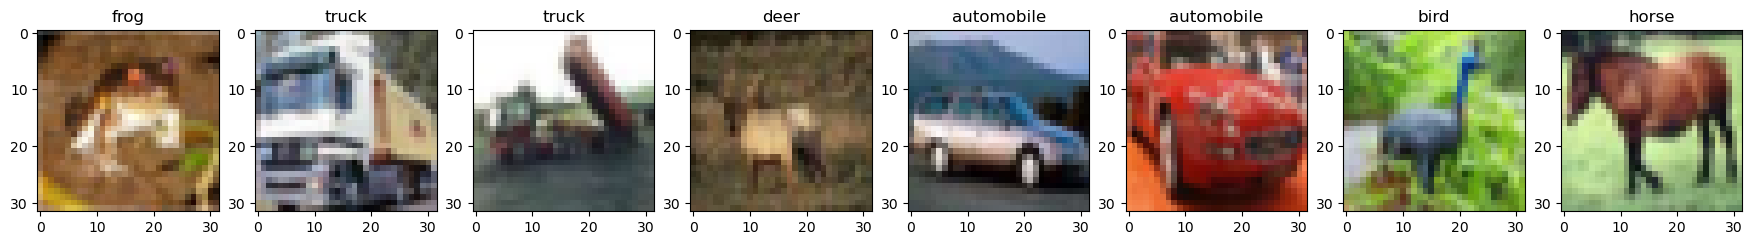

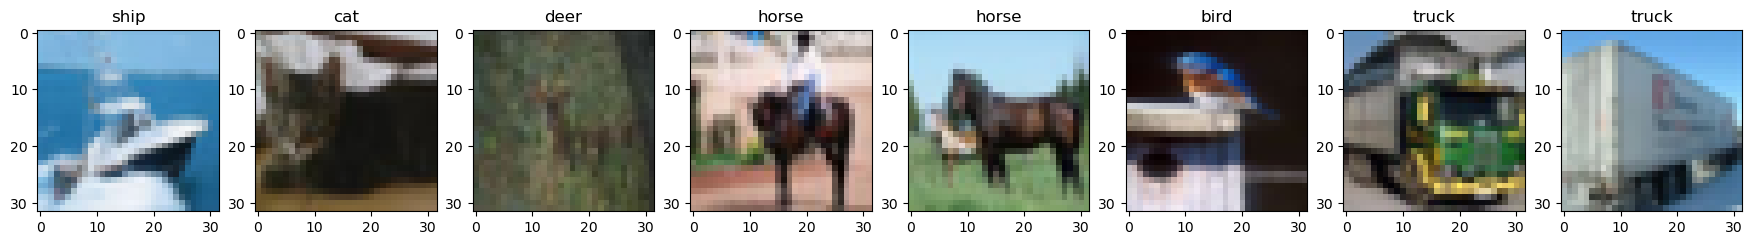

In [4]:
import matplotlib.pyplot as plt

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze() 
        axs[i].set_title(NAMES[int(label)])
        
show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

## Data preprocessing
* image array의 값을 0 ~ 1 사이 값으로 변환
* label array 인코딩
* Tensorflow는 tf.float32임

In [5]:
def get_preprocessed_data(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

train_images, train_labels = get_preprocessed_data(train_images, train_labels)
test_images, test_labels = get_preprocessed_data(test_images, test_labels)

In [6]:
train_images[0, :, :, :]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [7]:
print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 1)


In [8]:
print(train_labels[:10])

[[6.]
 [9.]
 [9.]
 [4.]
 [1.]
 [1.]
 [2.]
 [7.]
 [8.]
 [3.]]


## Custom Model 생성

In [9]:
IMAGE_SIZE = 32

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , \
                Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping ,\
                ModelCheckpoint , LearningRateScheduler

In [10]:
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) 

In [11]:
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')\
    (input_tensor)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

In [12]:
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

In [15]:
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
#x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        36928     
                                                             

### Model 학습 수행 및 테스트 데이터로 평가

In [17]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
history = model.fit(x=train_images, y=train_labels, batch_size=64, epochs=30,validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 335s 500ms/step - loss: 1.6725 - accuracy: 0.3750 - val_loss: 1.3466 - val_accuracy: 0.5145
Epoch 2/30
665/665 [==============================] - 375s 564ms/step - loss: 1.2267 - accuracy: 0.5581 - val_loss: 1.1261 - val_accuracy: 0.5964
Epoch 3/30
665/665 [==============================] - 373s 561ms/step - loss: 1.0061 - accuracy: 0.6447 - val_loss: 0.9193 - val_accuracy: 0.6787
Epoch 4/30
665/665 [==============================] - 312s 469ms/step - loss: 0.8905 - accuracy: 0.6843 - val_loss: 0.7835 - val_accuracy: 0.7200
Epoch 5/30
665/665 [==============================] - 228s 343ms/step - loss: 0.7907 - accuracy: 0.7201 - val_loss: 0.8103 - val_accuracy: 0.7207
Epoch 6/30
665/665 [==============================] - 148s 223ms/step - loss: 0.7262 - accuracy: 0.7453 - val_loss: 0.7284 - val_accuracy: 0.7436
Epoch 7/30
665/665 [==============================] - 125s 187ms/step - loss: 0.6580 - accuracy: 0.7659 - val_loss: 0.6888 -

313/313 [==============================] - 20s 64ms/step - loss: 0.7112 - accuracy: 0.8015


[0.7112026810646057, 0.8015000224113464]

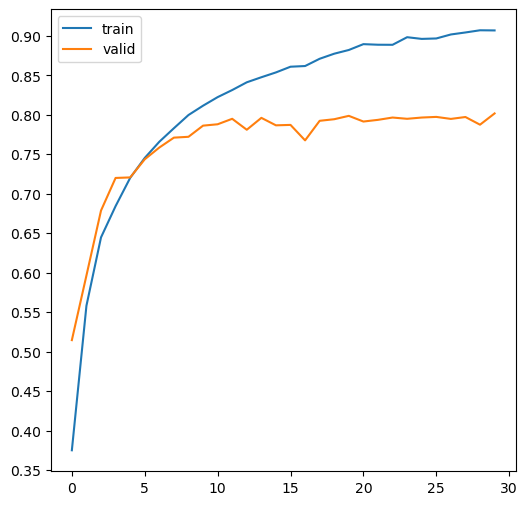

In [24]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6,6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'],label='valid')
    plt.legend()
    
show_history(history)
model.evaluate(test_images,test_labels)

### 이미지 분류 예측

In [25]:
preds = model.predict(test_images[0])

ValueError: in user code:

    File "C:\Users\LEEBYC\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\LEEBYC\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\LEEBYC\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\LEEBYC\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\LEEBYC\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\LEEBYC\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(32, 32, 3)


In [26]:
preds = model.predict(np.expand_dims(test_images[0],axis=0))
print('예측 결과 shape:',preds,shape)
print('예측 결과:',preds)


1/1 [==============================] - 0s 180ms/step


NameError: name 'shape' is not defined

In [ ]:
preds = model.predict(test_images[:32], batch_size=32)
print('예측 결과 shape:',preds.shape)
print('예측 결과:',preds)